## **Setup**

In [1]:
!git clone https://github.com/shubham-kanodia/crypto-jobs-scraper.git

DATA_DIR_PATH = "crypto-jobs-scraper/data"

Cloning into 'crypto-jobs-scraper'...
remote: Enumerating objects: 619, done.
remote: Counting objects: 100% (619/619), done.
remote: Compressing objects: 100% (609/609), done.
remote: Total 619 (delta 9), reused 618 (delta 8), pack-reused 0
Receiving objects: 100% (619/619), 1004.30 KiB | 715.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.


## Data Loading

In [2]:
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

web3_careers_company_files = glob(f"{DATA_DIR_PATH}/web3_careers/page_data/*.csv")

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]

In [4]:
jobs = []

for web3_careers_company_file in web3_careers_company_files:
  with open(web3_careers_company_file, "r", newline="") as file:
    reader = csv.reader(file)
    next(reader)

    for row in reader:
      job = {
          "company_name": row[0],
          "job_link": row[1],
          "job_title": row[2],
          "tags": row[4],
          "time_elapsed": row[5]
      }
      jobs.append(job)

with open(f"{DATA_DIR_PATH}/crypto_jobs_list/all_jobs.csv", "r", newline="") as file:
  reader = csv.reader(file)
  next(reader)

  for row in reader:
    job = {
          "company_name": row[0],
          "job_title": row[1],
          "tags": row[2],
          "time_elapsed": row[3] if not row[3][-1] == "m" else row[3] + "o"
      }
    jobs.append(job)

In [5]:
dataframe = pd.DataFrame({
    "company_name": [job["company_name"] for job in jobs],
    "job_title": [job["job_title"] for job in jobs],
    "tags": [job["tags"] for job in jobs],
    "time_elapsed": [job["time_elapsed"] for job in jobs]
})

In [6]:
jobs_with_salaries = []

for web3_careers_company_file in web3_careers_company_files:
  with open(web3_careers_company_file, "r", newline="") as file:
    reader = csv.reader(file)
    next(reader)

    for row in reader:
      if len(row[3].split("-")) >= 2:
        job = {
            "company_name": row[0],
            "job_title": row[2],
            "salary_range": row[3],
            "tags": row[4],
            "time_elapsed": row[5]
        }
        jobs_with_salaries.append(job)

In [7]:
dataframe_with_salaries = pd.DataFrame({
    "company_name": [job["company_name"] for job in jobs_with_salaries],
    "job_title": [job["job_title"] for job in jobs_with_salaries],
    "tags": [job["tags"] for job in jobs_with_salaries],
    "min_salary": [job["salary_range"].split("-")[0].strip().rstrip("k").lstrip("$") for job in jobs_with_salaries],
    "max_salary": [job["salary_range"].split("-")[1].strip().rstrip("k").lstrip("$") for job in jobs_with_salaries],
    "time_elapsed": [job["time_elapsed"] for job in jobs_with_salaries]
})

**Total Jobs:** 17268



## Analysis

### Smart Contract Jobs


#### Smart contract engineering jobs insights

**Total smart contract jobs when filtered with tags : `1774`**

- smart contract
- solidity
- rust

**How many new jobs in last x number of days/month/year:**

- 7d:	54
- 1m:	342
- 3m:	833
- 6m:	1723
- 1y:	1774

**Average salary of smart contract engineer is - `$82k - $170k`**

In [8]:
smart_contract_jobs = dataframe[dataframe["tags"].str.contains("smart contract") | dataframe["tags"].str.contains("solidity") | dataframe["tags"].str.contains("rust")]
smart_contract_rows_with_salaries = dataframe_with_salaries[dataframe_with_salaries["tags"].str.contains("smart contract") | dataframe_with_salaries["tags"].str.contains("solidity") | dataframe_with_salaries["tags"].str.contains("rust")]

f"Total smart contract jobs: {len(smart_contract_jobs)}"

'Total smart contract jobs: 1774'

In [9]:
def get_time_period_type(time_period):
  symbol = ""
  for char in time_period:
    if not char.isdigit():
      symbol += char
  return symbol

def check_lesser_than(lesser, greater):

  symbol_lesser = get_time_period_type(lesser)
  symbol_greater = get_time_period_type(greater)

  precedence = ['m', 'h', 'd', 'mo', 'y']
  if precedence.index(symbol_lesser) > precedence.index(symbol_greater):
    return False
  elif precedence.index(symbol_lesser) == precedence.index(symbol_greater):

    if int(lesser.rstrip(symbol_lesser)) <= int(greater.rstrip(symbol_greater)):
      return True
    else:
      return False
  else:
    return True

def cound_earlier_rows(time_period):
  freq = 0

  time_elapsed_values = smart_contract_jobs["time_elapsed"].values
  for time_elapsed_value in time_elapsed_values:
    try:
      if check_lesser_than(time_elapsed_value, time_period):
        freq += 1
    except Exception as exp:
      print(exp)
  
  return freq


In [10]:
time_periods = ["7d", "1mo", "3mo", "6mo", "1y"]

time_period_freq = {}

for time_period in time_periods:
  time_period_freq[time_period] = cound_earlier_rows(time_period)

time_period_data = pd.DataFrame(time_period_freq.items(), columns=["Time Period", "Frequency"], index=None)

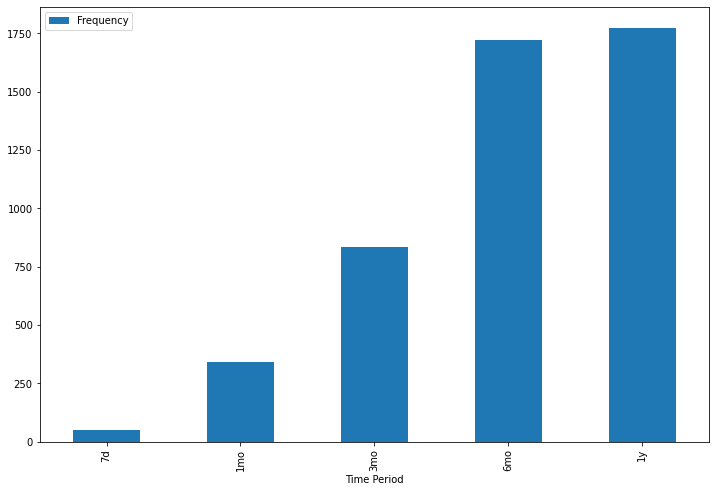

In [11]:
fig, ax = plt.subplots()
time_period_data.plot(ax=ax, x="Time Period", kind="bar")

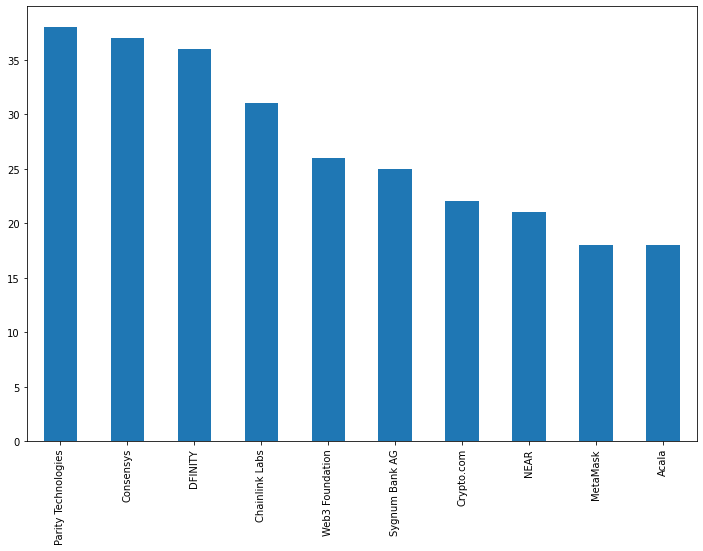

In [12]:
fig, ax = plt.subplots()
smart_contract_jobs["company_name"].value_counts()[:10].plot(ax=ax, kind='bar')

In [13]:
avg_min_salary = int(smart_contract_rows_with_salaries["min_salary"].astype(float).mean())
avg_max_salary = int(smart_contract_rows_with_salaries["max_salary"].astype(float).mean())

(avg_min_salary, avg_max_salary)

(82, 170)

### Jobs filtered with each tag

In [14]:
tags_column_values = list(dataframe["tags"].values)

tags = []
for tags_column_value in tags_column_values:
  tags.extend(tags_column_value.split(":"))

tags = set(tags)
tags.remove("")

In [15]:
def count_tag(tag):
  tags_column_values = list(dataframe["tags"].values)
  freq = 0

  for tags_column_value in tags_column_values:
    if tag in tags_column_value.split(":"):
      freq += 1

  return freq

tag_frequency = {}

for tag in tags:
  tag_frequency[tag] = count_tag(tag)

In [16]:
tags_frequency_df = pd.DataFrame(tag_frequency.items(), columns=["tag", "frequency"], index=None)

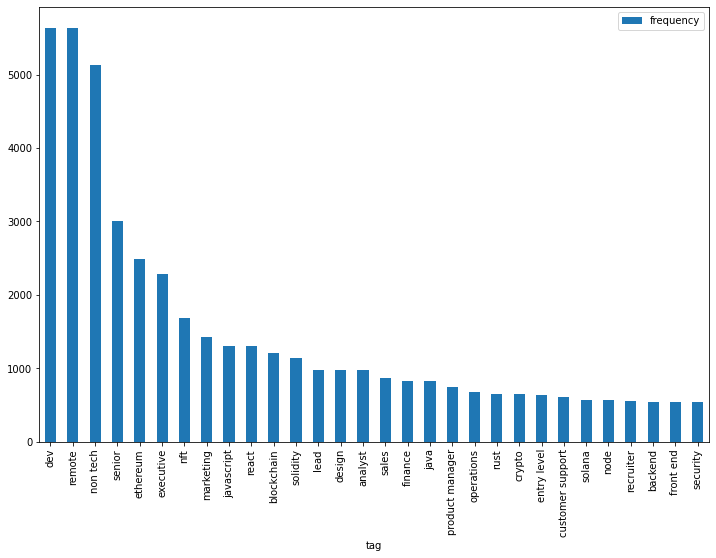

In [17]:
fig, ax = plt.subplots()
tags_frequency_df.sort_values(by="frequency", ascending=False)[:30].plot(ax=ax, x="tag", kind='bar')

### Companies with most blockchain jobs

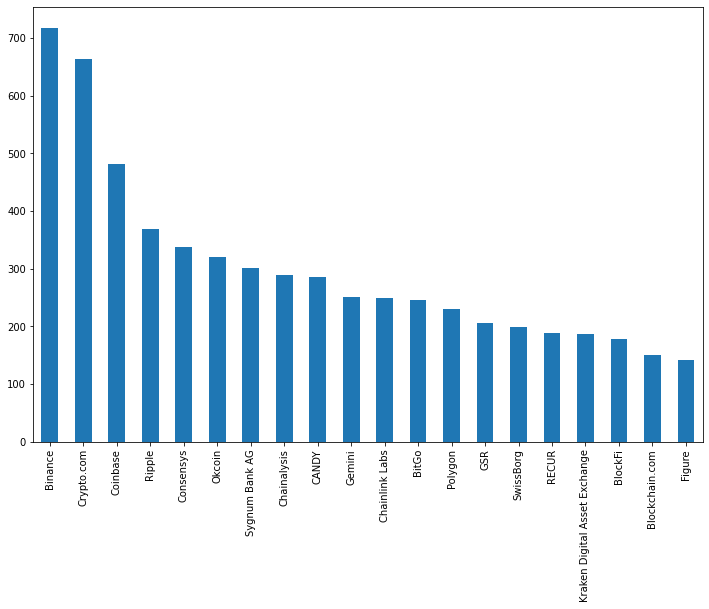

In [18]:
fig, ax = plt.subplots()
dataframe["company_name"].value_counts()[:20].plot(ax=ax, kind='bar')